# Helpers

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import matplotlib.pyplot as plt

def _ifft2c(data: torch.Tensor, norm: str = "ortho") -> torch.Tensor:
    """
    Apply centered 2-dimensional Inverse Fast Fourier Transform.
    Args:
        data: Complex valued input data containing at least 3 dimensions:
            dimensions -3 & -2 are spatial dimensions and dimension -1 has size
            2. All other dimensions are assumed to be batch dimensions.
        norm: Normalization mode. See ``torch.fft.ifft``.
    Returns:
        The IFFT of the input.
    """
    if not data.shape[-1] == 2:
        raise ValueError("Tensor does not have separate complex dim.")

    data = torch.fft.ifftshift(data, dim=[-3, -2])
    data = torch.view_as_real(
        torch.fft.ifftn(  # type: ignore
            torch.view_as_complex(data), dim=(-2, -1), norm=norm
        )
    )
    data = torch.fft.fftshift(data, dim=[-3, -2])
    return data

def _complex_abs_sq(data: torch.Tensor) -> torch.Tensor:
    """
    Compute the squared absolute value of a complex tensor.
    Args:
        data: A complex valued tensor, where the size of the final dimension
            should be 2.
    Returns:
        Squared absolute value of data.
    """
    if not data.shape[-1] == 2:
        raise ValueError("Tensor does not have separate complex dim.")

    return (data**2).sum(dim=-1)


def _rss_complex(data: torch.Tensor, dim: int = 0) -> torch.Tensor:
    """
    Compute the Root Sum of Squares (RSS) for complex inputs.
    RSS is computed assuming that dim is the coil dimension.
    Args:
        data: The input tensor
        dim: The dimensions along which to apply the RSS transform
    Returns:
        The RSS value.
    """
    return torch.sqrt(_complex_abs_sq(data).sum(dim))

def print_image(image):
    """
    Display an image of shape (C, H, W). The image can be either a numpy array or a PyTorch tensor.
    
    Args:
        image (np.ndarray or torch.Tensor): Image with shape (C, H, W).
            - For a single-channel image (C=1), it will be displayed as grayscale.
            - For a 3-channel image (C=3), it will be displayed as a color image.
    """
    # Convert tensor to numpy array if necessary.
    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy()

    # Ensure the image has three dimensions.
    if image.ndim != 3:
        raise ValueError(f"Expected image with 3 dimensions (C, H, W), got shape {image.shape}")

    C, H, W = image.shape
    
    # If the image is single-channel, remove the channel dimension and display in grayscale.
    if C == 1:
        # Remove the channel dimension: from (1, H, W) to (H, W)
        image_to_show = image[0]
        plt.imshow(image_to_show, cmap='gray')
    elif C == 3:
        # Convert from (C, H, W) to (H, W, C)
        image_to_show = np.transpose(image, (1, 2, 0))
        plt.imshow(image_to_show)
    else:
        raise ValueError(f"Unsupported number of channels: {C}. Only 1 or 3 channels are supported.")

    plt.axis("off")
    plt.show()

def _complex_mul(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Complex multiplication.
    This multiplies two complex tensors assuming that they are both stored as
    real arrays with the last dimension being the complex dimension.
    Args:
        x: A PyTorch tensor with the last dimension of size 2.
        y: A PyTorch tensor with the last dimension of size 2.
    Returns:
        A PyTorch tensor with the last dimension of size 2.
    """
    if not x.shape[-1] == y.shape[-1] == 2:
        raise ValueError("Tensors do not have separate complex dim.")

    re = x[..., 0] * y[..., 0] - x[..., 1] * y[..., 1]
    im = x[..., 0] * y[..., 1] + x[..., 1] * y[..., 0]

    return torch.stack((re, im), dim=-1)

def _complex_conj(x: torch.Tensor) -> torch.Tensor:
    """
    Complex conjugate.
    This applies the complex conjugate assuming that the input array has the
    last dimension as the complex dimension.
    Args:
        x: A PyTorch tensor with the last dimension of size 2.
        y: A PyTorch tensor with the last dimension of size 2.
    Returns:
        A PyTorch tensor with the last dimension of size 2.
    """
    if not x.shape[-1] == 2:
        raise ValueError("Tensor does not have separate complex dim.")

    return torch.stack((x[..., 0], -x[..., 1]), dim=-1)


def _sens_reduce(x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
    return _complex_mul(
        _ifft2c(x), _complex_conj(sens_maps)
    ).sum(dim=1, keepdim=True)

import matplotlib.pyplot as plt
import numpy as np
import torch

def display_image_grid(image_grid, row_labels=None, col_labels=None):
    """
    Display a grid of images with 3 columns, with optional row and column labels.

    Args:
        image_grid (List[List[np.ndarray or torch.Tensor]]): Nested list of images with shape (C, H, W).
        row_labels (List[str], optional): Labels for each row.
        col_labels (List[str], optional): Labels for each column.
    """
    num_rows = len(image_grid)
    num_cols = len(image_grid[0]) if num_rows > 0 else 0

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    axs = np.array(axs)

    # Ensure axs is always 2D
    if num_rows == 1:
        axs = axs[np.newaxis, :]

    for i in range(num_rows):
        for j in range(num_cols):
            ax = axs[i, j]
            ax.axis("off")

            try:
                image = image_grid[i][j]
            except IndexError:
                continue

            if isinstance(image, torch.Tensor):
                image = image.detach().cpu().numpy()

            if image.ndim != 3:
                raise ValueError(f"Expected image with 3 dimensions (C, H, W), got shape {image.shape}")

            C, H, W = image.shape
            if C == 1:
                ax.imshow(image[0], cmap='gray')
            elif C == 3:
                ax.imshow(np.transpose(image, (1, 2, 0)))
            else:
                raise ValueError(f"Unsupported number of channels: {C}. Only 1 or 3 supported.")

    # Add row labels
    if row_labels:
        for i, label in enumerate(row_labels):
            axs[i, 0].set_ylabel(label, fontsize=12, rotation=90, labelpad=10, va='center')

    # Add column labels
    if col_labels:
        for j, label in enumerate(col_labels):
            axs[0, j].set_title(label, fontsize=12)

    plt.tight_layout()
    plt.show()

def plot_multi_method_comparison(
    x_labels,
    method_results,
    ylabel="PSNR [dB] →",
    title="Reconstruction on Different Undersampling Patterns",
    annotate_index=None,
    annotate_offset=(0.1, 0.3),
    figsize=(7, 4),
    fontsize=12,
    linewidth=2,
    marker='o',
    use_legend=False
):
    """
    Plots multiple methods on a line chart with custom annotations or legend.

    Parameters:
    - x_labels (List[str]): Categories for the x-axis.
    - method_results (Dict[str, Dict[str, Any]]): Dictionary where each key is a method label.
        Each value is a dict with keys:
            - "values": List of y-values
            - "color": Plot color
    - ylabel (str): Y-axis label.
    - title (str): Plot title.
    - annotate_index (int): Index on x-axis to place annotations (defaults to middle).
    - annotate_offset (tuple): (x_offset, y_offset) offset for annotation placement.
    - figsize (tuple): Size of the figure.
    - fontsize (int): Font size for labels.
    - linewidth (float): Width of lines.
    - marker (str): Marker type (e.g., 'o', 's', '^').
    - use_legend (bool): Whether to use legend instead of inline annotation.
    """
    x = list(range(len(x_labels)))
    if annotate_index is None:
        annotate_index = len(x) // 2

    plt.figure(figsize=figsize)

    for label, config in method_results.items():
        y_vals = config["values"]
        color = config.get("color", None)
        plt.plot(x, y_vals, marker + '-', color=color, label=label, linewidth=linewidth)

        if not use_legend:
            x_offset, y_offset = annotate_offset
            plt.text(
                x[annotate_index] + x_offset,
                y_vals[annotate_index] + y_offset,
                label,
                color=color,
                fontsize=fontsize
            )

    plt.xticks(x, x_labels, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel("Undersampling Pattern", fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.title(title, fontsize=fontsize + 1)

    if use_legend:
        plt.legend(fontsize=fontsize - 2)

    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.show()

def find_unused_modules(model, example_inputs):
    used = set()
    hooks = []

    # Register a hook on every submodule
    for name, mod in model.named_modules():
        def hook_fn(_mod, _in, _out, *, nm=name):
            used.add(nm)
        hooks.append(mod.register_forward_hook(hook_fn))

    # Run one pass
    with torch.no_grad():
        _ = model(*example_inputs)

    # Clean up hooks
    for h in hooks:
        h.remove()

    all_names = [name for name, _ in model.named_modules()]
    unused = [n for n in all_names if n not in used]
    return used, unused

def find_unused_modules(model, example_inputs):
    used = set()
    hooks = []

    # Register a hook on every submodule
    for name, mod in model.named_modules():
        def hook_fn(_mod, _in, _out, *, nm=name):
            used.add(nm)
        hooks.append(mod.register_forward_hook(hook_fn))

    # Run one pass
    with torch.no_grad():
        _ = model(*example_inputs)

    # Clean up hooks
    for h in hooks:
        h.remove()

    all_names = [name for name, _ in model.named_modules()]
    unused = [n for n in all_names if n not in used]
    return used, unused


# What does SKM-Tea looks like

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
print("hello world")

hello world


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def _ifft2c(data: torch.Tensor, norm: str = "ortho") -> torch.Tensor:
    """
    Apply centered 2-dimensional Inverse Fast Fourier Transform.
    Args:
        data: Complex valued input data containing at least 3 dimensions:
            dimensions -3 & -2 are spatial dimensions and dimension -1 has size
            2. All other dimensions are assumed to be batch dimensions.
        norm: Normalization mode. See ``torch.fft.ifft``.
    Returns:
        The IFFT of the input.
    """
    if not data.shape[-1] == 2:
        raise ValueError("Tensor does not have separate complex dim.")

    data = torch.fft.ifftshift(data, dim=[-3, -2])
    data = torch.view_as_real(
        torch.fft.ifftn(  # type: ignore
            torch.view_as_complex(data), dim=(-2, -1), norm=norm
        )
    )
    data = torch.fft.fftshift(data, dim=[-3, -2])
    return data

def _complex_abs_sq(data: torch.Tensor) -> torch.Tensor:
    """
    Compute the squared absolute value of a complex tensor.
    Args:
        data: A complex valued tensor, where the size of the final dimension
            should be 2.
    Returns:
        Squared absolute value of data.
    """
    if not data.shape[-1] == 2:
        raise ValueError("Tensor does not have separate complex dim.")

    return (data**2).sum(dim=-1)


def _rss_complex(data: torch.Tensor, dim: int = 0) -> torch.Tensor:
    """
    Compute the Root Sum of Squares (RSS) for complex inputs.
    RSS is computed assuming that dim is the coil dimension.
    Args:
        data: The input tensor
        dim: The dimensions along which to apply the RSS transform
    Returns:
        The RSS value.
    """
    return torch.sqrt(_complex_abs_sq(data).sum(dim))

def print_image(image):
    """
    Display an image of shape (C, H, W). The image can be either a numpy array or a PyTorch tensor.
    
    Args:
        image (np.ndarray or torch.Tensor): Image with shape (C, H, W).
            - For a single-channel image (C=1), it will be displayed as grayscale.
            - For a 3-channel image (C=3), it will be displayed as a color image.
    """
    # Convert tensor to numpy array if necessary.
    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy()

    # Ensure the image has three dimensions.
    if image.ndim != 3:
        raise ValueError(f"Expected image with 3 dimensions (C, H, W), got shape {image.shape}")

    C, H, W = image.shape
    
    # If the image is single-channel, remove the channel dimension and display in grayscale.
    if C == 1:
        # Remove the channel dimension: from (1, H, W) to (H, W)
        image_to_show = image[0]
        plt.imshow(image_to_show, cmap='gray')
    elif C == 3:
        # Convert from (C, H, W) to (H, W, C)
        image_to_show = np.transpose(image, (1, 2, 0))
        plt.imshow(image_to_show)
    else:
        raise ValueError(f"Unsupported number of channels: {C}. Only 1 or 3 channels are supported.")

    plt.axis("off")
    plt.show()

def _complex_mul(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Complex multiplication.
    This multiplies two complex tensors assuming that they are both stored as
    real arrays with the last dimension being the complex dimension.
    Args:
        x: A PyTorch tensor with the last dimension of size 2.
        y: A PyTorch tensor with the last dimension of size 2.
    Returns:
        A PyTorch tensor with the last dimension of size 2.
    """
    if not x.shape[-1] == y.shape[-1] == 2:
        raise ValueError("Tensors do not have separate complex dim.")

    re = x[..., 0] * y[..., 0] - x[..., 1] * y[..., 1]
    im = x[..., 0] * y[..., 1] + x[..., 1] * y[..., 0]

    return torch.stack((re, im), dim=-1)

def _complex_conj(x: torch.Tensor) -> torch.Tensor:
    """
    Complex conjugate.
    This applies the complex conjugate assuming that the input array has the
    last dimension as the complex dimension.
    Args:
        x: A PyTorch tensor with the last dimension of size 2.
        y: A PyTorch tensor with the last dimension of size 2.
    Returns:
        A PyTorch tensor with the last dimension of size 2.
    """
    if not x.shape[-1] == 2:
        raise ValueError("Tensor does not have separate complex dim.")

    return torch.stack((x[..., 0], -x[..., 1]), dim=-1)


def _sens_reduce(x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
    return _complex_mul(
        _ifft2c(x), _complex_conj(sens_maps)
    ).sum(dim=1, keepdim=True)

In [11]:
patient_name = "MTR_001"
slice = "0"

file_name = patient_name + "_" + slice

kspace = np.load(f"datasets/processed_skm/kspace/{file_name}.npy", allow_pickle=True).item()
label = np.load(f"datasets/processed_skm/label/{file_name}.npy", allow_pickle=True).item()

In [23]:
label['patellar_cartilage'].shape

(512, 512)

In [27]:
ks = kspace['kspace'].permute(2, 0, 1)
sens = torch.tensor(kspace['map']).squeeze().permute(2, 0, 1)

## RSS 

In [45]:
x_i = []
for i in range(16):
    x_i.append(_ifft2c(torch.view_as_real(ks[i])))
x_i = torch.stack(x_i, dim=0)

In [49]:
x = _rss_complex(x_i)

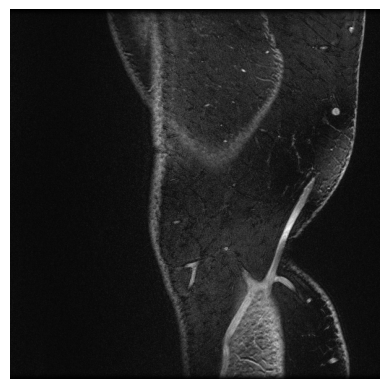

In [55]:
print_image(x.unsqueeze(dim=0))

## Using Sens maps

In [61]:
torch.conj(sens).shape

torch.Size([16, 512, 512])

In [107]:
x_i = []
for i in range(16):
    x_i.append(_ifft2c(torch.view_as_real(ks[i])))
x_i = torch.stack(x_i, dim=0)

In [131]:
x = torch.view_as_complex(x_i) * torch.conj(sens)
x = torch.sum(x, dim = 0)
s_r = _rss_complex(torch.view_as_real(sens))
# x = x / (s_r * s_r)

In [132]:
x_fin = _complex_abs_sq(torch.view_as_real(x))**0.5

In [133]:
x_fin.shape

torch.Size([512, 512])

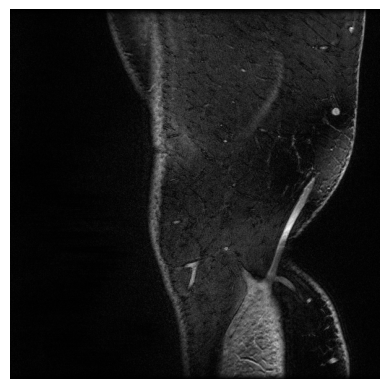

In [134]:
print_image(x_fin.unsqueeze(dim=0))

### Alternative

In [135]:
x = _sens_reduce(torch.view_as_real(ks.unsqueeze(dim=0)), torch.view_as_real(sens.unsqueeze(dim=0))).squeeze()
x = _rss_complex(x.unsqueeze(dim=0))

In [136]:
x.shape

torch.Size([512, 512])

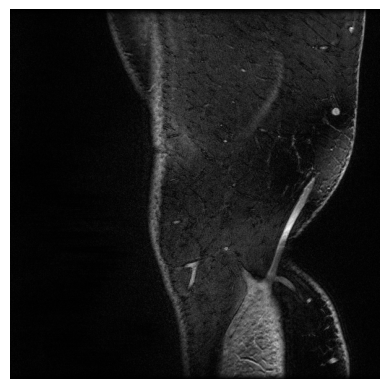

In [137]:
print_image(x.unsqueeze(dim=0))

In [147]:
#  get top 10 values in x - x_fin
x_temp = x - x_fin
x_temp = x_temp.view(-1)
x_temp = x_temp.abs()
x_temp = x_temp.sort(descending=True)

print(x_temp.values[:100])

tensor([8., 8., 8., 8., 8., 8., 8., 6., 6., 6., 6., 6., 6., 6., 6., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])


# Debugging NO-MRI's worse performance on SKM-TEA

In [2]:
import torch
import argparse
from fvcore.common.config import CfgNode as CN
from codesign.config.config import CodesignConfigurator

class Args:
    config = "results/<your-exp-name>/config.yaml"
    fix = None

    def __init__(self, config, fix=None):
        self.config = config
        self.fix = fix
        

/global/homes/p/peterwg/pscratch/aujasvit/tackle-baseline/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### NO-Varnet [Kernel Shape: (3, 4); Radius: 0.02]

In [6]:
# folder = "results/novarnet-recon_16x_2-cascade_ks[3,4]_rc0.02"
folder = "results/novarnet-recon_16x_2-cascade_ks[3,4]_rc0.02_fixsad"
args = Args(config=f"{folder}/config.yaml", 
            fix=[
                "init_modules", '["sampler", "reconstructor"]',
                'init_module_trainability', '[False, False]'
            ]
            )

cc = CodesignConfigurator(args)
exp, model, data_module = cc.init_all()
data_module.setup("validate")
val_loader = data_module.val_dataloader()
val_iter = iter(val_loader)
kspace = []
images = []
segmentation_labels = []
for i in range(1):
    batch = next(val_iter)
    kspace.append(batch[0])
    images.append(batch[1])
    segmentation_labels.append(batch[2])

-------> validation set: 974 batches of size 1 (974 samples in total) <-------


In [9]:
kspace_masked, masks, recon, recon_zf = [], [], [], []
no34_images = []
for i in range(len(kspace)):
    temp = model.sampler(kspace[i])
    kspace_masked.append(temp[0])
    masks.append(temp[1])
    f = model.reconstructor(kspace_masked[i], masks[i])
    recon.append(f[0])
    recon_zf.append(f[1])
    # print(masks[i].shape, recon_zf[i].shape, recon[i].shape, images[i].shape)
    no34_images.append([masks[i], recon_zf[i].squeeze(dim=0), recon[i].squeeze(dim=0), images[i].squeeze(dim=0)])

# hehe = _ifft2c(torch.view_as_real(kspace_masked))
# f = model.reconstructor(kspace_masked, mask)
# print_image(f[1].squeeze(dim=1))
# print_image(f[0].squeeze(dim=1))
# print_image(images[0].squeeze(dim=1))

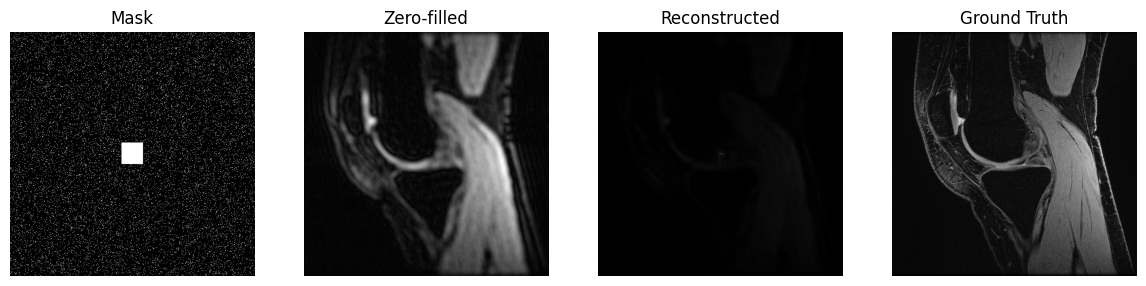

In [10]:
display_image_grid(no34_images, col_labels=["Mask", "Zero-filled", "Reconstructed", "Ground Truth"],)

In [28]:
used, unused = find_unused_modules(model.reconstructor, [kspace_masked[0], masks[0]])

torch.Size([1, 8, 512, 512, 2])


In [29]:
print(unused)

['sens_net.norm_undno.udno.down_sample_layers', 'sens_net.norm_undno.udno.up', 'sens_net.norm_undno.udno.up_transpose', 'kno', 'kno.udno', 'kno.udno.down_sample_layers', 'kno.udno.down_sample_layers.0', 'kno.udno.down_sample_layers.0.layers', 'kno.udno.down_sample_layers.0.layers.0', 'kno.udno.down_sample_layers.0.layers.1', 'kno.udno.down_sample_layers.0.layers.2', 'kno.udno.down_sample_layers.0.layers.3', 'kno.udno.down_sample_layers.0.layers.4', 'kno.udno.down_sample_layers.0.layers.5', 'kno.udno.down_sample_layers.0.layers.6', 'kno.udno.down_sample_layers.0.layers.7', 'kno.udno.down_sample_layers.1', 'kno.udno.down_sample_layers.1.layers', 'kno.udno.down_sample_layers.1.layers.0', 'kno.udno.down_sample_layers.1.layers.1', 'kno.udno.down_sample_layers.1.layers.2', 'kno.udno.down_sample_layers.1.layers.3', 'kno.udno.down_sample_layers.1.layers.4', 'kno.udno.down_sample_layers.1.layers.5', 'kno.udno.down_sample_layers.1.layers.6', 'kno.udno.down_sample_layers.1.layers.7', 'kno.udno.do

### NO-Varnet [Kernel Shape: (7,6); Radius: 0.02]

-------> validation set: 974 batches of size 1 (974 samples in total) <-------


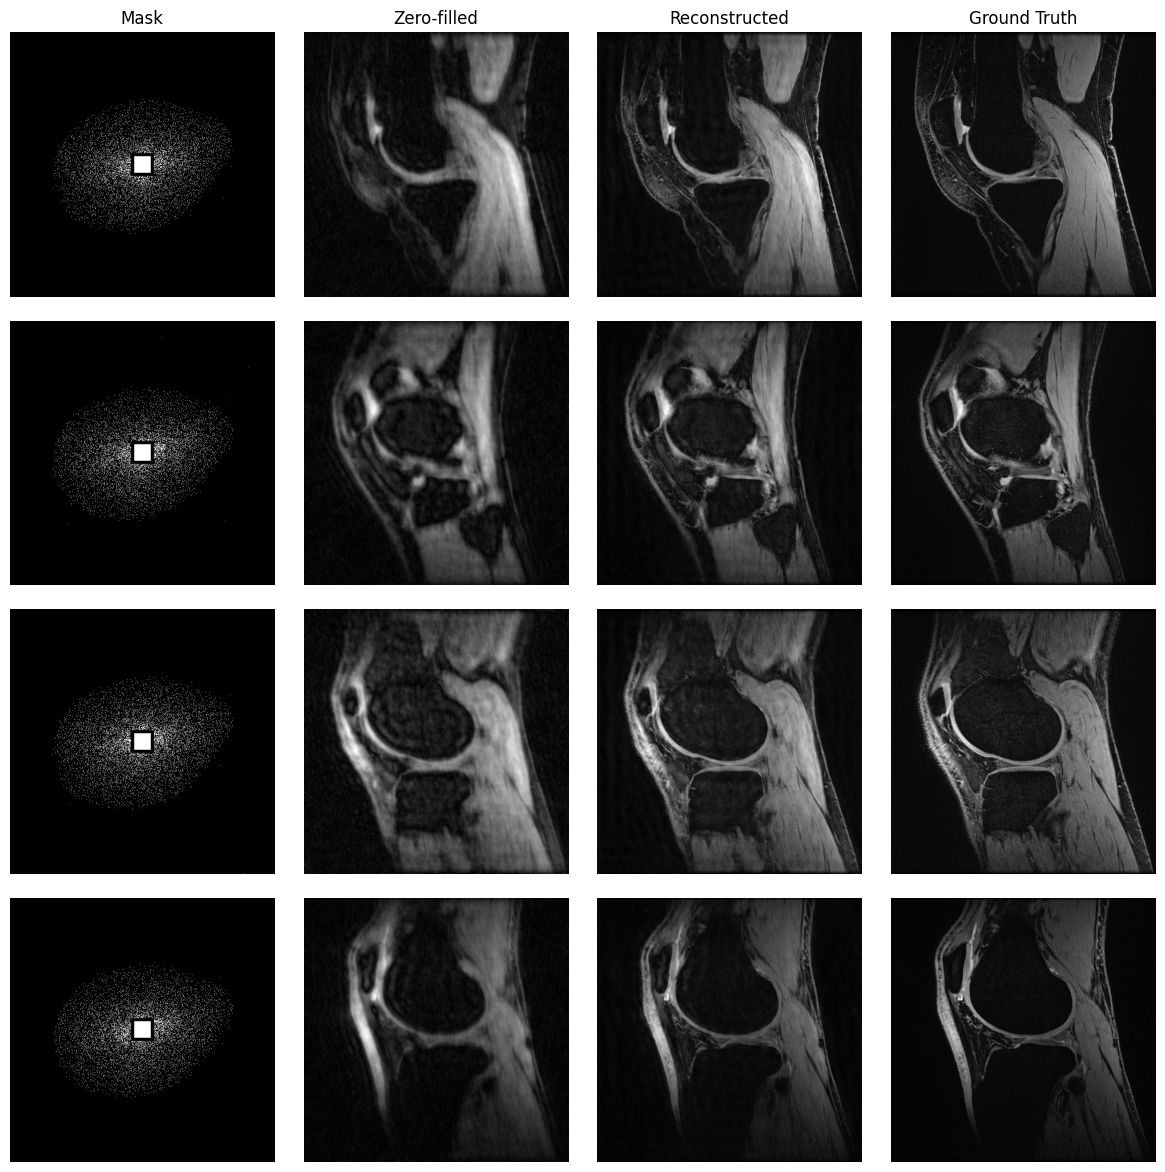

In [ ]:
folder = "novarnet-recon_16x_2-cascade_ks[7,6]_rc0.02"
args = Args(config=f"{folder}/config.yaml", 
            fix=[
                "init_modules", '["sampler", "reconstructor"]',
                'init_module_trainability', '[False, False]'
            ]
            )

cc = CodesignConfigurator(args)
exp, model, data_module = cc.init_all()
data_module.setup("validate")
val_loader = data_module.val_dataloader()
val_iter = iter(val_loader)
kspace = []
images = []
segmentation_labels = []
for i in range(4):
    batch = next(val_iter)
    kspace.append(batch[0])
    images.append(batch[1])
    segmentation_labels.append(batch[2])


kspace_masked, masks, recon, recon_zf = [], [], [], []
no76_images = []
for i in range(len(kspace)):
    temp = model.sampler(kspace[i])
    kspace_masked.append(temp[0])
    masks.append(temp[1])
    f = model.reconstructor(kspace_masked[i], masks[i])
    recon.append(f[0])
    recon_zf.append(f[1])
    no76_images.append([masks[i], recon_zf[i].squeeze(dim=0), recon[i].squeeze(dim=0), images[i].squeeze(dim=0)])

display_image_grid(no76_images, col_labels=["Mask", "Zero-filled", "Reconstructed", "Ground Truth"],)

# hehe = _ifft2c(torch.view_as_real(kspace_masked))
# f = model.reconstructor(kspace_masked, mask)
# print_image(f[1].squeeze(dim=1))
# print_image(f[0].squeeze(dim=1))
# print_image(images[0].squeeze(dim=1))

### E2E-Varnet

-------> validation set: 974 batches of size 1 (974 samples in total) <-------


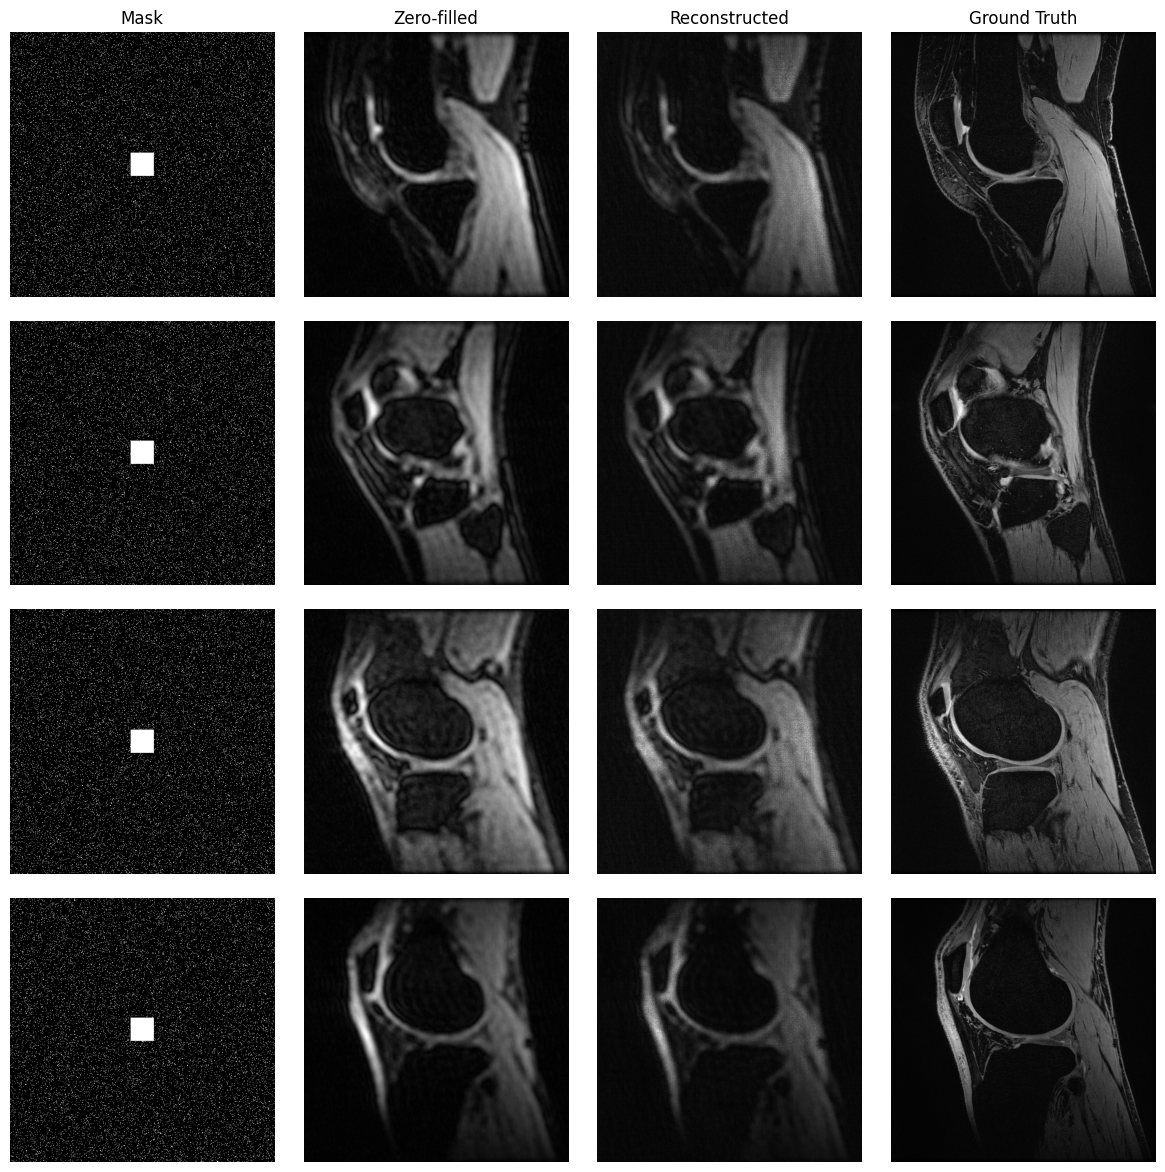

In [ ]:
folder = "results/tacklenew-recon_16x_2-cascade"
args = Args(config=f"{folder}/config.yaml", 
            fix=[
                "init_modules", '["sampler", "reconstructor"]',
                'init_module_trainability', '[False, False]'
            ]
            )

cc = CodesignConfigurator(args)
exp, model, data_module = cc.init_all()
data_module.setup("test")
val_loader = data_module.val_dataloader()
val_iter = iter(val_loader)
kspace = []
images = []
segmentation_labels = []
for i in range(4):
    batch = next(val_iter)
    kspace.append(batch[0])
    images.append(batch[1])
    segmentation_labels.append(batch[2])


kspace_masked, masks, recon, recon_zf = [], [], [], []
e2e_images = []
for i in range(len(kspace)):
    temp = model.sampler(kspace[i])
    kspace_masked.append(temp[0])
    masks.append(temp[1])
    f = model.reconstructor(kspace_masked[i], masks[i])
    recon.append(f[0])
    recon_zf.append(f[1])
    e2e_images.append([masks[i], recon_zf[i].squeeze(dim=0), recon[i].squeeze(dim=0), images[i].squeeze(dim=0)])

display_image_grid(e2e_images, col_labels=["Mask", "Zero-filled", "Reconstructed", "Ground Truth"],)
# hehe = _ifft2c(torch.view_as_real(kspace_masked))
# f = model.reconstructor(kspace_masked, mask)
# print_image(f[1].squeeze(dim=1))
# print_image(f[0].squeeze(dim=1))
# print_image(images[0].squeeze(dim=1))

### Comparison

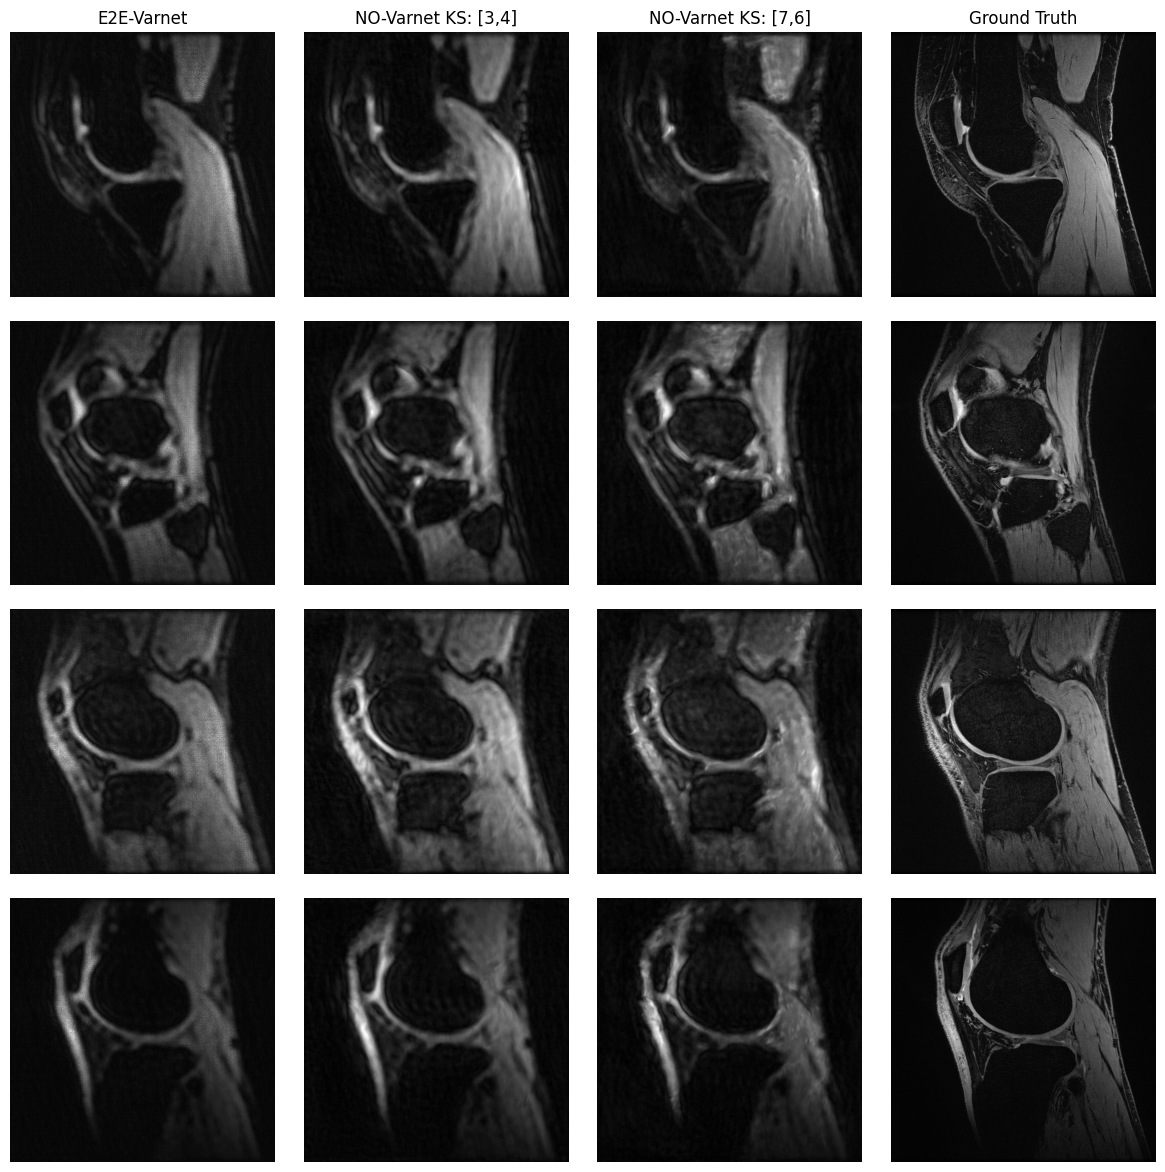

In [17]:
compare_images = []
for i in range(len(kspace)):
    compare_images.append([e2e_images[i][2], no34_images[i][2], no76_images[i][2], images[i].squeeze(dim=0)])

display_image_grid(compare_images,col_labels=["E2E-Varnet", "NO-Varnet KS: [3,4]", "NO-Varnet KS: [7,6]", "Ground Truth"],)

### Fine-tuning on different rates (Reconstruction)

In [ ]:
rates = ["8x", "16x", "32x", "64x"]
no_accuracy = []
e2e_accuracy = []


In [ ]:
patterns = ['8x', '16x', '32x', '64x']

method_results = {
    "NO (KS: [3,4])": {
        "values": [36.34, 32.00, 34.93, 32.89],
        "color": "red"
    },
    "CNN": {
        "values": [33.72, 32.08, 30.33, 28.35],
        "color": "blue"
    },
    # "Transformer": {
    #     "values": [38.0, 37.5, 38.3, 36.0, 37.2, 38.8],
    #     "color": "green"
    # }
}

plot_multi_method_comparison(patterns, method_results)


In [ ]:
dir_list = []
batch, kspace, images, segmentation_labels = [], [], [], []

images = []

for dir in dir_list:
    folder = dir
    args = Args(config=f"{folder}/config.yaml", 
                fix=[
                    "init_modules", '["sampler", "reconstructor"]',
                    'init_module_trainability', '[False, False]'
                ]
                )

    cc = CodesignConfigurator(args)
    exp, model, data_module = cc.init_all()
    data_module.setup("validate")
    val_loader = data_module.val_dataloader()
    val_iter = iter(val_loader)
    kspace = []
    images = []
    segmentation_labels = []

    if batch == []:
        for i in range(1):
            batch = next(val_iter)
            kspace.append(batch[0])
            images.append(batch[1])
            segmentation_labels.append(batch[2])


    kspace_masked, masks, recon, recon_zf = [], [], [], []
    for i in range(len(kspace)):
        temp = model.sampler(kspace[i])
        kspace_masked.append(temp[0])
        masks.append(temp[1])
        f = model.reconstructor(kspace_masked[i], masks[i])
        recon.append(f[0])
        recon_zf.append(f[1])
        images.append([masks[i], recon_zf[i].squeeze(dim=0), recon[i].squeeze(dim=0), images[i].squeeze(dim=0)])

# Play

In [35]:
folder = "results/novarnet-recon_16x_2-cascade_ks[3,4]_rc0.02_fix_idk"
args = Args(config=f"{folder}/config.yaml", 
            fix=[
                "init_modules", '["sampler", "reconstructor"]',
                'init_module_trainability', '[False, False]'
            ]
            )

cc = CodesignConfigurator(args)
exp, model, data_module = cc.init_all()
data_module.setup("validate")
test_dataloader = data_module.val_dataloader()
val_loader = test_dataloader
# val_iter = iter(val_loader)
# kspace = []
# images = []
# segmentation_labels = []
# for i in range(4):
#     batch = next(val_iter)
#     kspace.append(batch[0])
#     images.append(batch[1])
#     segmentation_labels.append(batch[2])


# kspace_masked, masks, recon, recon_zf = [], [], [], []
# no76_images = []
# for i in range(len(kspace)):
#     temp = model.sampler(kspace[i])
#     kspace_masked.append(temp[0])
#     masks.append(temp[1])
#     f = model.reconstructor(kspace_masked[i], masks[i])
#     recon.append(f[0])
#     recon_zf.append(f[1])
#     no76_images.append([masks[i], recon_zf[i].squeeze(dim=0), recon[i].squeeze(dim=0), images[i].squeeze(dim=0)])

# display_image_grid(no76_images, col_labels=["Mask", "Zero-filled", "Reconstructed", "Ground Truth"],)

# hehe = _ifft2c(torch.view_as_real(kspace_masked))
# f = model.reconstructor(kspace_masked, mask)
# print_image(f[1].squeeze(dim=1))
# print_image(f[0].squeeze(dim=1))
# print_image(images[0].squeeze(dim=1))

-------> validation set: 974 batches of size 1 (974 samples in total) <-------


In [20]:
from codesign.reconstructors.udno_recon.no_varnet import sens_expand, sens_reduce
from codesign.utils.complex_to_chan import complex_to_chan
from codesign.utils.ifftn import ifftn_
from codesign.utils.multicoil_ops import _fft2c, _rss


ks, m = model.sampler(kspace[0])
sens_maps = model.reconstructor.sens_net(ks, m, model.reconstructor.acs_ratio)

old_image = complex_to_chan(ifftn_(ks, dim=[-2, -1]), chan_dim=1, num_chan=1)
old_image = _rss(old_image, dim=2)

kspace_pred = ks.clone()
kspace_pred = torch.view_as_real(kspace_pred) 
ref_kspace = torch.view_as_real(ks) 
x_reduced = sens_reduce(kspace_pred, sens_maps)
k_reduced = _fft2c(x_reduced)
# kspace_pred = k_reduced.clone() + model.reconstructor.kno(k_reduced) 
kspace_pred = _ifft2c(kspace_pred)
kspace_pred = sens_expand(kspace_pred, sens_maps)

for cascade in model.reconstructor.cascades:
    kspace_pred = cascade(kspace_pred, ref_kspace, m, sens_maps)
# print(kspace_pred.shape)

new_image = complex_to_chan(ifftn_(torch.view_as_complex(kspace_pred), dim=[-2, -1]).squeeze(1), chan_dim=1, num_chan=1)
new_image = _rss(new_image, dim=2)

hehe = model.reconstructor(ks, m)

In [ ]:
import pytorch_lightning as pl
trainer = pl.Trainer(
    accelerator='gpu', 
    # devices=4, 
    devices=4, 
    # strategy=DDPStrategy(find_unused_parameters=False), 
    # logger=logger,
    # callbacks=[
    #     checkpoint_callback, 
    #     early_stop_callback,
    #     *additional_callbacks
    # ],
    # profiler=pl.profilers.SimpleProfiler(),
    **dict(model.cfg.trainer)
)
trainer.test(model, dataloaders=test_dataloader)

/global/homes/p/peterwg/pscratch/aujasvit/tackle-baseline/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/p/peterwg/pscratch/aujasvit/tackle-bas ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: results/novarnet-recon_16x_2-cascade_ks[3,4]_rc0.02_fix_idk/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1012/1012 [01:14<00:00, 13.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_psnr            23.00562286376953
     test_psnr_loss         -23.00562286376953
      test_zf_psnr           24.55280876159668
    test_zf_psnr_loss       -24.55280876159668
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_psnr_loss': -23.00562286376953,
  'test_psnr': 23.00562286376953,
  'test_zf_psnr_loss': -24.55280876159668,
  'test_zf_psnr': 24.55280876159668}]

/global/homes/p/peterwg/pscratch/aujasvit/tackle-baseline/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/p/peterwg/pscratch/aujasvit/tackle-bas ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


RuntimeError: Lightning can't create new processes if CUDA is already initialized. Did you manually call `torch.cuda.*` functions, have moved the model to the device, or allocated memory on the GPU any other way? Please remove any such calls, or change the selected strategy. You will have to restart the Python kernel.

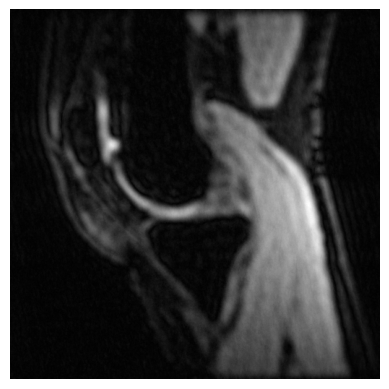

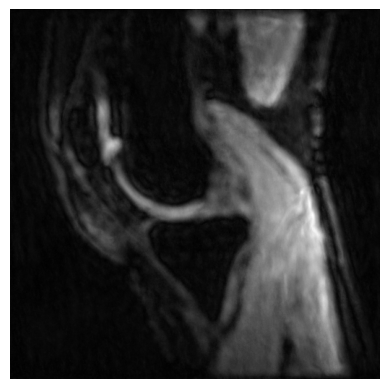

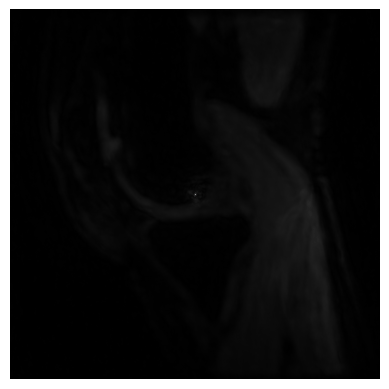

In [21]:
print_image(old_image.squeeze(dim=0))
print_image(new_image.squeeze(dim=0))
print_image(hehe[0].squeeze(dim=0))

In [22]:
from codesign.losses.psnr_loss import PSNR

psnr = PSNR()

print(psnr(old_image.squeeze(dim=0), images[0]))
print(psnr(new_image.squeeze(dim=0), images[0]))
print(psnr(hehe[0].squeeze(dim=0), images[0]))


tensor(26.4378, grad_fn=<NegBackward0>)
tensor(26.5121, grad_fn=<NegBackward0>)
tensor(25.7842, grad_fn=<NegBackward0>)
